In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import numpy as np
import matplotlib.pyplot as plt
import math

# Predizione della qualità di un vino partendo da risultati di test fisico-chimici
Il dataset è disponibile pubblicamente online (https://archive.ics.uci.edu/ml/datasets/Wine+Quality) e viene fornito (per rapidità/semplicità) in formato numpy (.npz) per quest'esercitazione (winequality-white.npz e winequality-red.npz). 

La matrice fornita nella variabile x ha dimensioni Nobs x 11 (vini bianchi: Nobs=4898; vini rossi: Nobs=1599). Le righe rappresentano le diverse osservazioni, mentre le colonne rappresentano le feature:
```
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
```
I valori contenuti nel vettore y (contenente Nobs valori) rappresentano un indice di qualità (output feature), che varia tra 0-10. Il task di regressione consiste nella predizione dell'indice di qualità a partire dalle 11 input feature.

1.   Caricare il dataset winequality-red.npz, dividerlo in un training (80%) set e test set (20%) e standardizzare i dati impiegando valor medio e deviazione standard del training set
2.   Creare un multi-layer perceptron (MLP) con 2 strati nascosti con 64 unità ciascuno (rectified linear units, ReLU come funzione di attivazione).
3. Addestrare il modello per 250 epoche impiegando l'ottimizzatore Stochastic Gradient Descent (learning rate=1e-3, batch size=64) e la funzione costo Mean Squared Error. Testare il modello sul test set.
4. Visualizzare l'errore valutato sul training set in funzione delle epoche di addestramento.



In [43]:
# Prepare the dataset.

data = np.load('winequality-red.npz') # /path/to/winequality-red.npz
x = data['x']
y = data['y']
print(x.shape)
print(y.shape)

(1599, 11)
(1599,)


(1599, 11)
(1599,)
Number of input features: 11
Number of total examples: 1599
Training set number of examples: 1279
Test set number of examples: 320
Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer)  [(None, 11)]             0         
                                                                 
 dense_layer0 (Dense)        (None, 64)                768       
                                                                 
 dense_layer1 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer2 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer_output (Dense)  (None, 1)                 65        
                                                                 
Total params: 9,153
Trainable params: 9,153
N

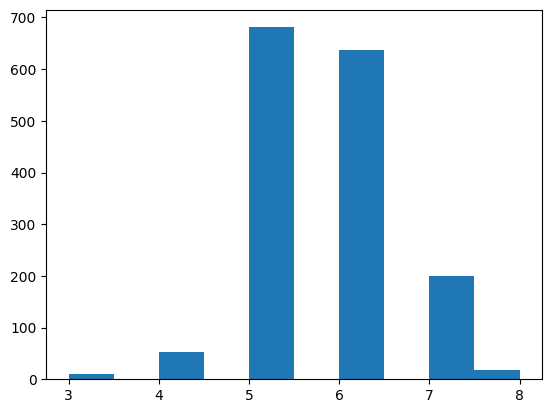

In [44]:
# Prepare the dataset.
data = np.load('winequality-red.npz') # /path/to/winequality-red.npz
x = data['x']
y = data['y']
print(x.shape)
print(y.shape)
plt.hist(y)
ntot_examples = x.shape[0]
nfeatures = x.shape[-1]
nexamples = math.floor(0.8*ntot_examples)

print('Number of input features: {0}'.format(nfeatures))
print('Number of total examples: {0}'.format(ntot_examples))
print('Training set number of examples: {0}'.format(nexamples))
print('Test set number of examples: {0}'.format(ntot_examples-nexamples))
x_train = x[:nexamples,:]
y_train = y[:nexamples]

x_test = x[nexamples:, :]
y_test = y[nexamples:]

mean_train = x_train.mean(axis=0) # osserv. x feature
std_train = x_train.std(axis=0)
x_train -= mean_train
x_train /= std_train
x_test -= mean_train
x_test /= std_train

# Model design.  (keras (tensorflow), tensorflow, pytorch)
inputs = keras.Input(shape=(nfeatures,), name="input_features")
# Posso diminuire anche il numero di unita'
#x1 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer0')(inputs)
x1 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer0')(inputs)
x2 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer1')(x1)
x3 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer2')(x2)
outputs = layers.Dense(1, name="dense_layer_output")(x3)
model = keras.Model(inputs=inputs, outputs=outputs, name='MLP')
model.summary()
# Instantiate an optimizer.
# Momentum per superare i minimi locali per favorire la convergenza al minimo assoluto
# e nel minimo tempo possibile
#optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)# , momentum=0.9

# Uso ADAM
optimizer = keras.optimizers.Adam(learning_rate=1e-3)# , momentum=0.9
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

In [45]:
nepochs = 50#250
bs = 64
nexamples = x_train.shape[0]

idx_start = np.arange(0, x_train.shape[0], bs)
idx_stop = np.roll(idx_start, shift=-1)
idx_stop[-1] = x_train.shape[0]

nbatches = idx_start.shape[0]
# x_train: (1279, 11)
# epoca 1
# mini-batch 1: [0, 64] 64 esempi, 1 iterazione
# mini-batch 2: [64, 128] 64 esempi, 2 iterazione
# ...
# mini-batch 20: [1216, 1279] <64 esempi (1279 non divisibile 64), 20ma iterazione

# epoca 2
# mini-batch 1: [0, 64] 64 esempi, 1 iterazione
#...
# mini-batch 20: [1216, 1279] <64 esempi (1279 non divisibile 64), 20ma iterazione
#...

# epoca 50
print('Number of batches ({0} examples, {1} mini-batch size): {2}, first: {3}, last: {4}'.format(nexamples, bs, nbatches, 
                                                             [idx_start[0], idx_stop[0]],
                                                             [idx_start[-1], idx_stop[-1]]))

Number of batches (1279 examples, 64 mini-batch size): 20, first: [0, 64], last: [1216, 1279]


In [46]:
nepochs = 50#250
bs = 64
nexamples = x_train.shape[0]

idx_start = np.arange(0, x_train.shape[0], bs)
idx_stop = np.roll(idx_start, shift=-1)
idx_stop[-1] = x_train.shape[0]

nbatches = idx_start.shape[0]
print('Number of batches ({0} examples, {1} mini-batch size): {2}, first: {3}, last: {4}'.format(nexamples, bs, nbatches, 
                                                             [idx_start[0], idx_stop[0]],
                                                             [idx_start[-1], idx_stop[-1]]))
seed = 1234
np.random.seed(seed)

# Iterate over epochs.
train_losses = []
train_losses_it = []
for epoch in np.arange(nepochs): # epoca 0: epoca 49
    # Shuffling training data at the start of each epoch
    idx = np.arange(x_train.shape[0]) # idx: [0,1,2,...,1278] valori da 0 a 1279
    np.random.shuffle(idx)# idx: [100, 2, 5, 1, 137, 7,...] valori da 0 a 1279
    loss = []
    # Iterate over the batches of the dataset.
    for step in np.arange(nbatches): # step 0: step 19
        # Extracting mini-batch.
        # idx_start[step=0] = 0, idx_stop[step=0] = 64
        # idx[idx_start[0]: idx_stop[0]]
        idx_batch = idx[idx_start[step]: idx_stop[step]] # 
        x_batch_train = x_train[idx_batch, :]
        y_batch_train = y_train[idx_batch]
        # Converting numpy arrays to tensorflow tensors.
        x_batch_train = tf.convert_to_tensor(x_batch_train)
        y_batch_train = tf.convert_to_tensor(y_batch_train)
        # Open a GradientTape to record the operations run during the forward-pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward-pass of the layer.
            preds = model(x_batch_train, training=True)
            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, preds)
        # Use the gradient tape to automatically retrieve the gradients of loss with respect to the trainable parameters.
        grads = tape.gradient(loss_value, model.trainable_weights)
        # Run one step of gradient descent by updating the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # grads: grad(L/w0), grad(L/w1),..., 
        # model.trainable_weights: w0, w1,..., 
        
        loss.append(loss_value) # lista di 20
    train_losses_it.extend(loss)
    train_loss = np.mean(loss)  # Averaging mini-batch losses
    print('Epoch {0}, train loss: {1}'.format(epoch, train_loss))
    train_losses.append(train_loss)

Number of batches (1279 examples, 64 mini-batch size): 20, first: [0, 64], last: [1216, 1279]
Epoch 0, train loss: 22.406909942626953
Epoch 1, train loss: 6.353909492492676
Epoch 2, train loss: 3.228389263153076
Epoch 3, train loss: 2.1524136066436768
Epoch 4, train loss: 1.7704992294311523
Epoch 5, train loss: 1.5205323696136475
Epoch 6, train loss: 1.3339592218399048
Epoch 7, train loss: 1.1778818368911743
Epoch 8, train loss: 1.0620253086090088
Epoch 9, train loss: 0.9316518902778625
Epoch 10, train loss: 0.8498347997665405
Epoch 11, train loss: 0.7647600173950195
Epoch 12, train loss: 0.694158136844635
Epoch 13, train loss: 0.6386095285415649
Epoch 14, train loss: 0.5894138813018799
Epoch 15, train loss: 0.5457693338394165
Epoch 16, train loss: 0.5143483281135559
Epoch 17, train loss: 0.4821080267429352
Epoch 18, train loss: 0.45608440041542053
Epoch 19, train loss: 0.43864211440086365
Epoch 20, train loss: 0.43239039182662964
Epoch 21, train loss: 0.417849600315094
Epoch 22, train

Text(0, 0.5, 'MSE (log)')

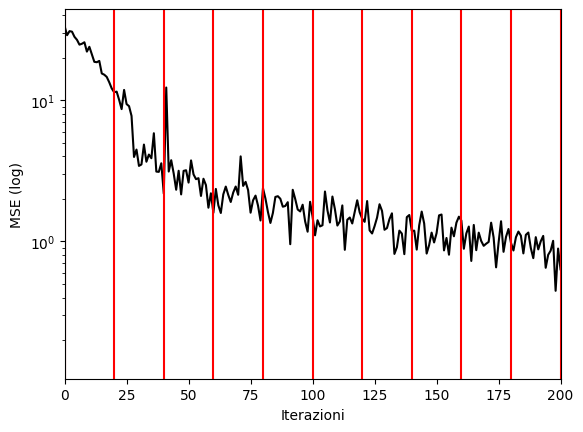

In [47]:
plt.semilogy(np.arange(nepochs*nbatches), train_losses_it, 'k')
for i in np.arange(0, nepochs*nbatches, nbatches):
    plt.axvline(i, c='r')
plt.xlim([0, 10*nbatches])
plt.xlabel('Iterazioni')
plt.ylabel('MSE (log)')
# potete plottare anche la funzione costo su singoli step (singoli mini-batch)
# valutare la variabilità (np.std) della funzione costo tra le valutazioni di mini-batch in 1 epoca
# variando il mini-batch size 

In [48]:
# Network evaluation at each epoch on both training and test set (alla fine ultima!!)
rmse_fn = tf.keras.metrics.RootMeanSquaredError()
mae_fn = tf.keras.metrics.MeanAbsoluteError()

preds = model(x_train, training=False)
train_rmse = rmse_fn(preds, tf.convert_to_tensor(y_train))
train_mae = mae_fn(preds, tf.convert_to_tensor(y_train))

preds = model(x_test, training=False)
test_rmse = rmse_fn(preds, tf.convert_to_tensor(y_test))
test_mae = mae_fn(preds, tf.convert_to_tensor(y_test))

print('Test RMSE: {0}, test MAE: {1}'.format(test_rmse, test_mae))


Test RMSE: 0.5382233262062073, test MAE: 0.4490564465522766


Keras introduce anche un metodo che realizza il ciclo di addestramento come realizzato sopra. Di seguito viene illustrato come eseguire l'addestramento chiamando il metodo 'fit' della classe 'Model' di Keras. Viene anche testato il modello in una cella separata.

In [49]:

# Model design. 
inputs = keras.Input(shape=(nfeatures,), name="input_features")
x1 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer0')(inputs)
x2 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer1')(x1)
x3 = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.L2(1e-4), bias_regularizer=regularizers.L2(1e-4),name='dense_layer2')(x2)
outputs = layers.Dense(1, name="dense_layer_output")(x3)
model = keras.Model(inputs=inputs, outputs=outputs, name='MLP')
model.summary()
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[rmse_fn,mae_fn])
model.fit(x=x_train,y=y_train,batch_size=bs,
          epochs=50,#250
          shuffle=True,
)

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_features (InputLayer)  [(None, 11)]             0         
                                                                 
 dense_layer0 (Dense)        (None, 64)                768       
                                                                 
 dense_layer1 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer2 (Dense)        (None, 64)                4160      
                                                                 
 dense_layer_output (Dense)  (None, 1)                 65        
                                                                 
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
20/20 [==============================] - 1s 2ms/st

In [50]:
# Network evaluation at each epoch on both training and test set (alla fine ultima!!)
preds = model(x_train, training=False)
train_rmse = rmse_fn(preds, tf.convert_to_tensor(y_train))
train_mae = mae_fn(preds, tf.convert_to_tensor(y_train))

preds = model(x_test, training=False)
test_rmse = rmse_fn(preds, tf.convert_to_tensor(y_test))
test_mae = mae_fn(preds, tf.convert_to_tensor(y_test))

print('Test RMSE: {0}, test MAE: {1}'.format(test_rmse, test_mae))

Test RMSE: 0.7881957292556763, test MAE: 0.6061281561851501


Ci sono alcuni parametri del modello o parametri della procedura di addestramento che possono influenzare la qualità della predizione del modello (cosiddetti 'iper-parametri'), come:
*   numero di strati nascosti (2, 3, 4, 5)
*   numero di unità nascoste (16, 32, 64, 128)
*   funzione di attivazione delle unità nascoste ('relu', 'elu')
*   inclusione di 'dropout' nella rete, dopo uno strato nascosto
*   tipologia di ottimizzatore ('SGD', 'SGD' con parametro momentum=0.9, 'Adam', 'RMSprop')
*   learning rate (1e-4, 5*1e-3, 1e-3)
*   mini-batch size (16, 32, 64)
*   numero di epoche di addestramento (100, 150, 200, 250, 300)

Questi sono solo alcuni dei principali iper-parametri introdotti. Fra parentesi sono indicati alcuni valori che potete testare (non sono necessari tutti) per vedere l'effetto di essi sulle metriche di performance. 

Addestrate il modello cambiando un iper-parametro alla volta (es. numero di strati nascosti=3 invece di 2 (default)) e registrate le metriche di prestazione che risultano da ogni modello addestrato. 

----30-40'
